In [1]:
import numpy as np
import pandas as pd
import io
import re
import string
from pymongo import MongoClient, UpdateOne

import nltk
nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from gensim import corpora, models, similarities, matutils
import pickle

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


# Import Podcast Episode Description Text Pickle

In [9]:
with open('pod_eps.pkl', 'rb') as f:
    text = pickle.load(f)

In [10]:
with open('pod_names.pkl', 'rb') as file:
    names = pickle.load(file)

# Use Nltk to Clean Text

In [11]:
german = []
spanish = []
french = []
scanda = []
misc = []
g_idx = []
s_idx = []
f_idx = []
sc_idx = []
msc_idx = []
ger_names = []
span_names = []
fren_names = []
scan_names = []
misc_names = []

for i, pod in enumerate(text):
    if re.search(r'\sund\s', pod) and re.search(r'\sder\s', pod):
        g_idx.append(i)
        german.append(text[i])
        ger_names.append(names[i])
        
for i, pod in enumerate(text):
    if (re.search(r'\scasa\s', pod) and (re.search(r'\spara\s', pod)) or re.search(r'\sque\s', pod)):
        s_idx.append(i)
        spanish.append(text[i])
        span_names.append(names[i])
        
for i, pod in enumerate(text):
    if re.search(r'pourquoi', pod) or ((re.search(r'\sles\s', pod) and re.search(r'\sest\s', pod))):
        f_idx.append(i)
        french.append(text[i])
        fren_names.append(names[i])
        
for i, pod in enumerate(text):
    if re.search(r'\soch\s', pod) or ((re.search(r'\som\s', pod) and re.search(r'\sog\s', pod))):
        sc_idx.append(i)
        scanda.append(text[i])
        scan_names.append(names[i])
        
for i, pod in enumerate(text):
    if re.search(r'bhagava\S*', pod) or re.search(r'سورة', pod) or re.search(r'محمد', pod) or re.search(r'[영화]', pod):
        msc_idx.append(i)
        misc.append(text[i])
        misc_names.append(names[i])
        
text = [pod for i, pod in enumerate(text) if i not in g_idx + s_idx + f_idx + sc_idx]
names = [name for i, name in enumerate(names) if i not in g_idx + s_idx + f_idx + sc_idx]

In [5]:
len(german + spanish + french + scanda + misc)/len(text)

0.047927199191102124

In [12]:
text = [t.lower() for t in text]

In [13]:
banned = [r'www\S*', r'podcast', r'\bep\S*', r'http\S*', r'week\S*',\
          r'facebook', r'twitter', r'itunes', r'android', r'\bnew\S*',\
          r"stitcher", r'\sios\s', r'ip\wd', r'audible\S*', r'\b[\.]*com\s',\
         r'time\S*', r'\btalk\S*', r'\blike\S*', r'discuss\S*', r'people',\
          r'sponsor\w*', r'subscri\S*', r'follow\S*', r'\bvisit\S*', r'website',\
         r'[eg]*mail\S*', r'\bpost\b', r'loyalbooks', r'just\b', r'know[ing]*', r'\bfree\b',\
         r'today', r'download\S*', r'iphone', r'\bmac\b', r'google', r'patreon',\
         r'\brss\b', r'spreaker', r'segment\S*', r'\bfe*a*t', r'\bfm\b', r'\balan\b', r'\bwatt\b']

In [14]:
remove_pat = '|'.join(map('{}'.format, banned))
remove_pat

'www\\S*|podcast|\\bep\\S*|http\\S*|week\\S*|facebook|twitter|itunes|android|\\bnew\\S*|stitcher|\\sios\\s|ip\\wd|audible\\S*|\\b[\\.]*com\\s|time\\S*|\\btalk\\S*|\\blike\\S*|discuss\\S*|people|sponsor\\w*|subscri\\S*|follow\\S*|\\bvisit\\S*|website|[eg]*mail\\S*|\\bpost\\b|loyalbooks|just\\b|know[ing]*|\\bfree\\b|today|download\\S*|iphone|\\bmac\\b|google|patreon|\\brss\\b|spreaker|segment\\S*|\\bfe*a*t|\\bfm\\b|\\balan\\b|\\bwatt\\b'

In [15]:
clean_text = [(re.sub(remove_pat, '', pod)) for pod in text] 
clean_text = [(re.sub('[%s]' %re.escape(string.punctuation),' ', pod)) for pod in clean_text]
clean_text = [(re.sub(r'(?<=[a-z])\r?\n|nbsp',' ', pod)) for pod in clean_text]

# Stemming

Now that many foreign language podcasts, punctuation, and capital letters are removed, I can remove suffixes through stemming. Additionally, now would be a good time to create a Doc-Term Matrix for Gensim to perform analysis. I do so by creating a Stemmed Count Vectorizer class that incorporates the stemmer into the count vectorizer method.

In [16]:
import Stemmer

In [17]:
english_stemmer = Stemmer.Stemmer('en')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))
    
scount = StemmedCountVectorizer(max_df=.25, min_df = .001, analyzer='word', token_pattern = "\\b[a-z][a-z]+\\b")
stem_counts = scount.fit_transform(clean_text).transpose()

In [75]:
stem_counts.shape

(48541, 9890)

In [ ]:
scount.vocabulary

# Create Doc-Term Matrix

This section is a vestige of earlier attempts to choose between a TFIDF (word frequency) vectorizer and a tradtional count vectorizer.

In [15]:
# tfidf_vectorizer = TfidfVectorizer(max_df = .1, min_df = .002, token_pattern = "\\b[a-z][a-z]+\\b")
# count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")

In [16]:
# tfidf_vectorizer.fit(clean_text)
# count_vectorizer.fit(clean_text)

In [17]:
# counts = tfidf_vectorizer.transform(clean_text).transpose()
# counts = count_vectorizer.transform(clean_text).transpose()

In [18]:
# pd.DataFrame(counts.toarray(), count_vectorizer.get_feature_names()).head(6)

In [19]:
# counts.shape

# Convert to Gensim Corpus

In [76]:
stem_corpus = matutils.Sparse2Corpus(stem_counts)

## Map matrix rows to words (tokens)

The first two cells were used to assses the performance of tfidf compared to a traditional count, as well as the length of the dictionary in order to confirm that it was created properly.

In [22]:
# id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
# id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [23]:
# len(id2word)

In [77]:
sid2word = dict((v, k) for k, v in scount.vocabulary_.items())

# LDA

At this point, it makes sense to perform Latent Dirichlet Analysis on the cleaned text to extract topics from podcasts, which will provide a better idea of the how podcasts group together.

I have also commented out some of the approaches with inferior results, as a means of making the notebook run faster.

In [25]:
# lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=7)

In [26]:
# lda.print_topics()

In [15]:
# stem_lda = models.LdaModel(corpus=stem_corpus, num_topics=25, id2word=sid2word, passes=10)

In [16]:
# stem_lda.print_topics()

In [78]:
stem_2 = models.LdaModel(corpus=stem_corpus, num_topics=15, id2word=sid2word, passes=10)

2018-03-05 16:26:30,171 : INFO : using symmetric alpha at 0.06666666666666667
2018-03-05 16:26:30,183 : INFO : using symmetric eta at 0.06666666666666667
2018-03-05 16:26:30,196 : INFO : using serial LDA version on this node
2018-03-05 16:26:35,436 : INFO : running online (multi-pass) LDA training, 15 topics, 10 passes over the supplied corpus of 9890 documents, updating model once every 2000 documents, evaluating perplexity every 9890 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-05 16:26:36,056 : INFO : PROGRESS: pass 0, at document #2000/9890
2018-03-05 16:26:45,627 : INFO : merging changes from 2000 documents into a model of 9890 documents
2018-03-05 16:26:47,499 : INFO : topic #13 (0.067): 0.004*"golf" + 0.003*"bibl" + 0.003*"poker" + 0.002*"psycholog" + 0.002*"entrepreneur" + 0.002*"church" + 0.002*"appl" + 0.002*"trump" + 0.002*"jesus" + 0.002*"rob"
2018-03-05 16:26:47,501 : INFO : topic #9 (0.067): 0.006*"appl" + 0.004*"pus" + 0.002*"cast" + 0.002*"c

In [79]:
stem_2.print_topics()

2018-03-05 16:40:13,035 : INFO : topic #0 (0.067): 0.014*"footbal" + 0.011*"preview" + 0.009*"fantasi" + 0.009*"nfl" + 0.008*"recap" + 0.007*"draft" + 0.006*"nba" + 0.006*"basketbal" + 0.006*"basebal" + 0.005*"leagu"
2018-03-05 16:40:13,037 : INFO : topic #1 (0.067): 0.008*"archiv" + 0.006*"london" + 0.005*"cigar" + 0.004*"uk" + 0.004*"museum" + 0.004*"island" + 0.003*"armi" + 0.003*"british" + 0.003*"amateur" + 0.003*"programm"
2018-03-05 16:40:13,039 : INFO : topic #2 (0.067): 0.023*"appl" + 0.008*"softwar" + 0.008*"mobil" + 0.007*"data" + 0.007*"comput" + 0.007*"user" + 0.006*"devic" + 0.005*"window" + 0.005*"pixel" + 0.005*"separ"
2018-03-05 16:40:13,042 : INFO : topic #3 (0.067): 0.014*"invest" + 0.010*"entrepreneur" + 0.009*"estat" + 0.007*"investor" + 0.006*"stock" + 0.006*"client" + 0.005*"amazon" + 0.005*"fund" + 0.005*"incom" + 0.004*"properti"
2018-03-05 16:40:13,046 : INFO : topic #4 (0.067): 0.012*"diet" + 0.011*"medic" + 0.010*"weight" + 0.010*"medicin" + 0.009*"patient" 

[(0,
  '0.014*"footbal" + 0.011*"preview" + 0.009*"fantasi" + 0.009*"nfl" + 0.008*"recap" + 0.007*"draft" + 0.006*"nba" + 0.006*"basketbal" + 0.006*"basebal" + 0.005*"leagu"'),
 (1,
  '0.008*"archiv" + 0.006*"london" + 0.005*"cigar" + 0.004*"uk" + 0.004*"museum" + 0.004*"island" + 0.003*"armi" + 0.003*"british" + 0.003*"amateur" + 0.003*"programm"'),
 (2,
  '0.023*"appl" + 0.008*"softwar" + 0.008*"mobil" + 0.007*"data" + 0.007*"comput" + 0.007*"user" + 0.006*"devic" + 0.005*"window" + 0.005*"pixel" + 0.005*"separ"'),
 (3,
  '0.014*"invest" + 0.010*"entrepreneur" + 0.009*"estat" + 0.007*"investor" + 0.006*"stock" + 0.006*"client" + 0.005*"amazon" + 0.005*"fund" + 0.005*"incom" + 0.004*"properti"'),
 (4,
  '0.012*"diet" + 0.011*"medic" + 0.010*"weight" + 0.010*"medicin" + 0.009*"patient" + 0.009*"nutrit" + 0.007*"diseas" + 0.006*"clinic" + 0.005*"exercis" + 0.005*"cancer"'),
 (5,
  '0.013*"disney" + 0.007*"instagram" + 0.006*"beer" + 0.004*"walt" + 0.004*"album" + 0.004*"comedi" + 0.004*

The above LDA seemed to work the best after running multiple models. Using the words above, I can form podcast topics, which are largely interpretable, although golf and religion seem to be grouped together.

In [19]:
# stem_3 = models.LdaModel(corpus=stem_corpus, num_topics=20, id2word=sid2word, passes=10)

In [20]:
# stem_3.print_topics()

In [21]:
# stem_4 = models.LdaModel(corpus=stem_corpus, num_topics=50, id2word=sid2word, passes=10)

In [22]:
# stem_4.print_topics()

In [80]:
lda_corpus = stem_2[stem_corpus]
lda_corpus

At this point, it becomes relevant to view the composition of topics for each podcast. I will limit my view to the first eight podcasts, as the output could easily become overwhelming.

In [ ]:
lda_docs = [doc for doc in lda_corpus]

In [82]:
lda_docs[0:7]

[[(0, 0.023595741),
  (2, 0.013221992),
  (3, 0.34246615),
  (4, 0.22924687),
  (5, 0.049745955),
  (6, 0.31535026),
  (12, 0.020348543)],
 [(6, 0.9978642)],
 [(0, 0.09189014),
  (3, 0.11957377),
  (5, 0.112752624),
  (6, 0.015359025),
  (7, 0.020071482),
  (8, 0.093733326),
  (11, 0.0130341975),
  (14, 0.5329706)],
 [(0, 0.0234324),
  (1, 0.1912951),
  (4, 0.027463336),
  (5, 0.032786187),
  (6, 0.08489706),
  (8, 0.11012615),
  (9, 0.34593624),
  (10, 0.022582628),
  (11, 0.015504745),
  (12, 0.103593975),
  (13, 0.013885837),
  (14, 0.02268579)],
 [(1, 0.058960546),
  (2, 0.23135671),
  (3, 0.039629746),
  (8, 0.34461388),
  (10, 0.1122657),
  (11, 0.02086281),
  (14, 0.18946876)],
 [(2, 0.041630343),
  (3, 0.020930732),
  (6, 0.34214967),
  (10, 0.018487928),
  (11, 0.017904706),
  (13, 0.52959335),
  (14, 0.018514626)],
 [(0, 0.5629765),
  (5, 0.08676767),
  (8, 0.017214492),
  (9, 0.042209312),
  (11, 0.05180912),
  (12, 0.20067868),
  (14, 0.010859575)]]

Some podcasts, like the second in this list, score very highly in one particular topic. Others can include multiple topics, but it is usually possible to determine one or two most descriptive topics.

In [83]:
lda_cluster = [max(doc,key=lambda item:item[1])[0] for doc in lda_docs]

In [84]:
lda_cluster[:12]

[3, 6, 14, 9, 8, 13, 0, 5, 3, 3, 0, 14]

# PCA

Perform Principle Compnonents Analysis to visualize podcast clusters. PCA reduces the dimensionality of my data from the fifteen topics to two principle meta-topics.

In [20]:
from sklearn.decomposition import PCA

In [21]:
import matplotlib.pyplot as plt

In [85]:
pca = PCA(n_components=2)
X = stem_counts.toarray().T

In [86]:
pca.fit(X)
pcafeatures = pca.transform(X)

In [87]:
# create a plot of the PCA results
from itertools import cycle

def plot_PCA_2D(data, topics, topic_names):
    colors = cycle(["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f"])
    topic_ids = range(len(topic_names))
    plt.figure(figsize=(15,15))
    for i, c, label in zip(topic_ids, colors, topic_names):
        plt.scatter(data[topics == i, 0], data[topics == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

In [28]:
pcafeatures[0:5]

array([[-5.46381734, -3.15825058],
       [-8.96615367, -4.09164221],
       [-8.04101087, -3.73506996],
       [-9.16288826, -3.76108735],
       [ 4.30102292, -2.97036747]])

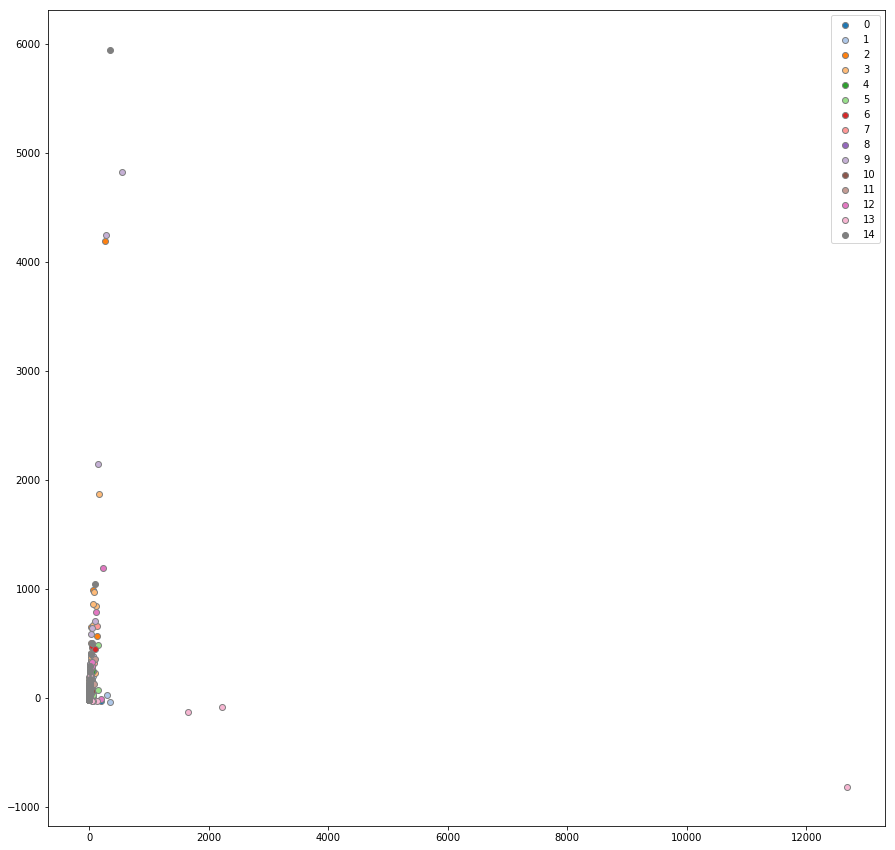

In [88]:
plot_PCA_2D(pcafeatures, topics=np.array(lda_cluster), topic_names=np.arange(15))

In [52]:
name_array = np.array(names).reshape(1,-1).T

In [89]:
lda_clusters = np.array(lda_cluster).reshape(1,-1).T

In [90]:
pod_tab_data = np.hstack((name_array, pcafeatures, lda_clusters))

Time to pickle the LDA topic data for tableau visualizations, which will be more interactive and allow for improved manipulation.

In [55]:
import pickle

with open('pod_tab_data.pkl', 'wb') as p:
    pickle.dump(pod_tab_data, p)

Screen Shot 2018-04-12 at 9.35.49 AM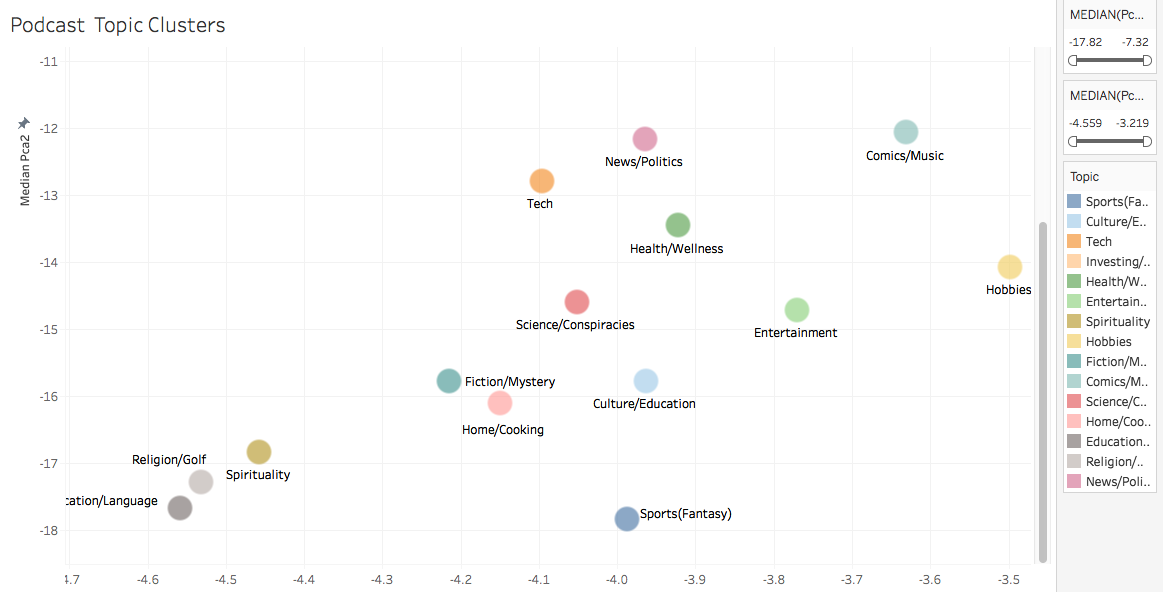

In [235]:
import pandas as pd 
df = pd.DataFrame(pod_tab_data, columns=['Podcast', 'PCA1', 'PCA2', 'Topic'])
df.to_csv("pod_tab_data.csv")

In [69]:
pod_tab_data[:5]

array([['Selling the Couch with Melvin Varghese, PhD | Weekly conversations to build and grow your counseling private practice',
        '-5.463817337534854', '-3.1582505808037067', '9'],
       ["Susan Gregg's Food for the Soul", '-8.966153671102946',
        '-4.091642214130476', '9'],
       ['Field Days', '-8.041010867043804', '-3.735069955743567', '10'],
       ["Card Talk: The World's Greatest Magic: the Gathering Podcast",
        '-9.162888261242202', '-3.7610873534251246', '6'],
       ['The UAV Digest', '4.301022923536863', '-2.970367471525103', '2']],
      dtype='<U127')

In [70]:
df.head()

,Podcast,PCA1,PCA2,Topic
0,"Selling the Couch with Melvin Varghese, PhD | ...",-5.463817337534854,-3.1582505808037067,9
1,Susan Gregg's Food for the Soul,-8.966153671102946,-4.091642214130476,9
2,Field Days,-8.041010867043804,-3.735069955743567,10
3,Card Talk: The World's Greatest Magic: the Gat...,-9.162888261242202,-3.7610873534251246,6
4,The UAV Digest,4.301022923536863,-2.970367471525103,2


# Recommender

On to the most exciting portion of the project - computing similarities in order to build out the recommender! I will use TruncatedSVD from sklearn to perform Latent Semantic Analysis on the cleaned episode description text and compute cosine similarities, which will analyze the angles between vectors created from the podcast text.

In [ ]:
import pickle
with open('stem_counts.pkl', 'rb') as p:
    stem_counts = pickle.load(p)

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
lsa = TruncatedSVD(100)

In [13]:
pod_lsa = lsa.fit_transform(stem_counts.transpose())
pod_lsa = Normalizer(copy=False).fit_transform(pod_lsa)

In [104]:
lsa.explained_variance_ratio_

array([0.05380799, 0.03952349, 0.03494654, 0.03291974, 0.03133785,
       0.02680167, 0.02056949, 0.02052675, 0.01781855, 0.01516379,
       0.01356472, 0.01261995, 0.01107793, 0.01037926, 0.00833773,
       0.00820745, 0.00760451, 0.0071229 , 0.00688208, 0.00672392,
       0.0066879 , 0.00658519, 0.00644144, 0.00636041, 0.00580165,
       0.00565015, 0.00554093, 0.00542702, 0.00532925, 0.0052821 ,
       0.00477642, 0.00464369, 0.00459065, 0.00451959, 0.00446884,
       0.00427812, 0.00426629, 0.00411208, 0.00397914, 0.00392626,
       0.00390808, 0.00387133, 0.00379892, 0.00373162, 0.00358703,
       0.00351607, 0.00341293, 0.00334989, 0.00325285, 0.00317202,
       0.00314523, 0.00304723, 0.00302909, 0.00299877, 0.00287037,
       0.00279194, 0.00271938, 0.00270016, 0.00258373, 0.00256307,
       0.0025277 , 0.00244197, 0.0023891 , 0.00234113, 0.0022902 ,
       0.00221011, 0.00218106, 0.00216615, 0.00216126, 0.00215136,
       0.00212644, 0.0020634 , 0.00204445, 0.00202116, 0.00198

Now, I will try to get a picture of how many singular values are necessary to explain the variance across podcasts.

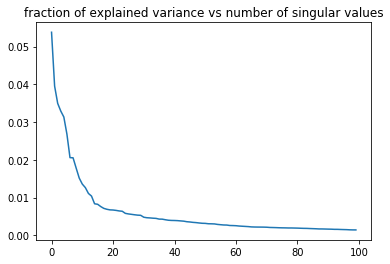

In [106]:
%matplotlib inline
plt.plot(lsa.explained_variance_ratio_)
plt.title('fraction of explained variance vs number of singular values');

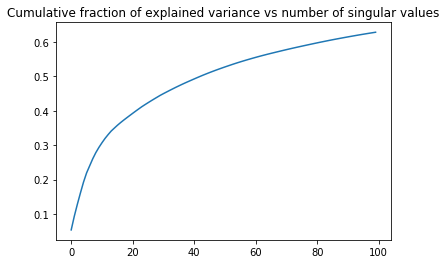

In [109]:
plt.plot(np.cumsum(lsa.explained_variance_ratio_))
plt.title('Cumulative fraction of explained variance vs number of singular values');

In [161]:
df.loc[df.Podcast == 'The Nerdist']

,Podcast,PCA1,PCA2,Topic
6676,The Nerdist,11.769205932376156,46.08877412647619,5


In [113]:
pod_lsa

array([[ 0.05029037,  0.30299665, -0.0026881 , ..., -0.12884569,
         0.08980181, -0.09327187],
       [ 0.02352757,  0.16432051, -0.03231894, ...,  0.04871397,
        -0.03205442, -0.00981146],
       [ 0.05717617,  0.35831941, -0.0322536 , ...,  0.18008694,
        -0.08172263, -0.12854893],
       ...,
       [ 0.0216236 ,  0.13139976,  0.02846763, ...,  0.00306396,
        -0.01461034, -0.1459697 ],
       [ 0.08786861,  0.30648377, -0.06490558, ...,  0.24563051,
        -0.05952327, -0.1142879 ],
       [ 0.05000137,  0.15401431, -0.01543737, ...,  0.18295242,
         0.10027116, -0.11734231]])

In [122]:
lsa.components_.shape

(100, 48541)

In [129]:
pod_lsa.shape

(9890, 100)

In [14]:
sims = cosine_similarity(pod_lsa)

Now it is time to check similarities using podcasts I know of or enjoy and compare the recommended podcasts using domain knowledge. Index 178 corresponds to Comedy Bang Bang.

In [214]:
df.iloc[np.argsort(sims[178]),0][-21:-1][::-1]

2430                            Bullseye with Jesse Thorn
6676                                          The Nerdist
4190                                     About Last Night
1141                             Stop Podcasting Yourself
7113                                      Ronna & Beverly
2708                                     Maltin on Movies
8767                               Pop My Culture Podcast
7097                                       Ask Me Another
7258                          WTF with Marc Maron Podcast
4235    Denzel Washington Is The Greatest Actor Of All...
2064                                         Gilmore Guys
630                        improv4humans with Matt Besser
2595                                      The Movie Crypt
9137                                        Truth & Iliza
8379                                  Be Here For A While
9649                             Kevin Pollak's Chat Show
8604                                  Black Girls Talking
9876          

In [173]:
cosine_similarity(pod_lsa[178].reshape(1,-1), pod_lsa[6676].reshape(1,-1))

array([[0.88209109]])

A friend brought to my attention "Hollywood Handbook," which is sort of a meta podcast with the intention of making fun of other podcasts. It seems to be succeeding in its aims, as the recommendations are for serious podcasts across a variety of genres.

In [179]:
df.loc[df.Podcast == 'Hollywood Handbook']

,Podcast,PCA1,PCA2,Topic
5399,Hollywood Handbook,-1.4002998704693355,-4.884880033103342,5


In [213]:
df.iloc[np.argsort(sims[5399]),0][-21:-1][::-1]

1940                                     Deal of the Week
9865                                         김영하의 책 읽는 시간
4704                                  Masters in Business
1928                                            Studio 10
3586                                     GovLoop Insights
8254                               Bloomberg Surveillance
1157                P&L With Pimm Fox and Lisa Abramowicz
1408                                            Decrypted
2389               Perino & Stirewalt: I'll Tell You What
2288       Tuesday Knight Podcast | All About Board Games
5036                         Bloomberg Business of Sports
6655                                   The Care Tags Show
8537                        Tomorrow with Joshua Topolsky
2710                                  Bloomberg Benchmark
3926                               Aesop's Fables Podcast
735                             Wynton Marsalis - Podcast
1778    The Self Publishing Podcast - Writing, Indie P...
5980          

In [181]:
lim_lsa = TruncatedSVD(18)

In [182]:
lim_pod_lsa = lim_lsa.fit_transform(stem_counts.transpose())
lim_pod_lsa = Normalizer(copy=False).fit_transform(lim_pod_lsa)

In [184]:
lim_sims = cosine_similarity(lim_pod_lsa)

In [212]:
df.iloc[np.argsort(lim_sims[178]),0][-21:-1][::-1]

7483                              The DS:Life Podcast
8771                                  The Poster Boys
7093    7th Son: Book Two - Deceit (The Beta Version)
6550                                      Fly With Me
832          Knights of the Night Actual Play Podcast
7505                                    Dev Game Club
1865                                The Sonic Society
958                                   Gilles Peterson
6655                               The Care Tags Show
842        Magic: The Gathering Drive to Work Podcast
464                                 Narrative Control
469                           Professional Book Nerds
230                           Happy Jacks RPG Podcast
3679                                       The Signal
5294                                         Ludology
9234                                          Sampler
5280                   The Lapse Storytelling Podcast
5480                                  WiiSpot Podcast
2372                        

In [16]:
fifty_lsa = TruncatedSVD(40)

In [17]:
fifty_pod_lsa = fifty_lsa.fit_transform(stem_counts.transpose())
fifty_pod_lsa = Normalizer(copy=False).fit_transform(fifty_pod_lsa)

In [18]:
fifty_sims = cosine_similarity(fifty_pod_lsa)

In [211]:
df.iloc[np.argsort(fifty_sims[178]),0][-21:-1][::-1]

6676                                          The Nerdist
2165                            Role Playing Public Radio
1724                         Doctor Who: Radio Free Skaro
8767                               Pop My Culture Podcast
2430                            Bullseye with Jesse Thorn
3013    Night of the Living Podcast: Horror, Sci-Fi an...
2595                                      The Movie Crypt
4182                                          Plot Points
8281                               The Collective Podcast
8379                                  Be Here For A While
3438                                         This Is Rad!
9649                             Kevin Pollak's Chat Show
458                               Kicked in the Dicebags!
6131                                 The Erasable Podcast
7097                                       Ask Me Another
5355                                   Happy Sad Confused
4306                                          Popspotting
7717          

In [18]:
rid_lsa = TruncatedSVD(500)

In [19]:
rid_pod_lsa = rid_lsa.fit_transform(stem_counts.transpose())
rid_pod_lsa = Normalizer(copy=False).fit_transform(rid_pod_lsa)

In [20]:
rid_sims = cosine_similarity(rid_pod_lsa)

2430                            Bullseye with Jesse Thorn
6676                                          The Nerdist
4190                                     About Last Night
1141                             Stop Podcasting Yourself
7113                                      Ronna & Beverly
2708                                     Maltin on Movies
8767                               Pop My Culture Podcast
7097                                       Ask Me Another
7258                          WTF with Marc Maron Podcast
4235    Denzel Washington Is The Greatest Actor Of All...
2064                                         Gilmore Guys
630                        improv4humans with Matt Besser
2595                                      The Movie Crypt
9137                                        Truth & Iliza
8379                                  Be Here For A While
9649                             Kevin Pollak's Chat Show
8604                                  Black Girls Talking
9876                                    The Writers Panel
7498                        Q: The Podcast from CBC Radio
1732                                 Retro Old Time Radio

In [210]:
df.iloc[np.argsort(rid_sims[178]),0][-21:-1][::-1]

4190                                     About Last Night
6676                                          The Nerdist
251                        That Story Show – clean comedy
5330                               How Did This Get Made?
7145                                Old Time Comedy Radio
9177                   You Made It Weird with Pete Holmes
8379                                  Be Here For A While
1671                           Ari Shaffir's Skeptic Tank
118                                          Tinder Tales
9649                             Kevin Pollak's Chat Show
9137                                        Truth & Iliza
630                        improv4humans with Matt Besser
5166                                      wellRED podcast
2590          The Champs with Neal Brennan + Moshe Kasher
8007                      Chewin' It with Kevin and Steve
4960                          UCB Long-Form Conversations
2205                    Black Men Can't Jump In Hollywood
5572          

In [209]:
df.iloc[np.argsort(rid_sims[5399]),0][-21:-1][::-1]

2288       Tuesday Knight Podcast | All About Board Games
787                            Coffee With a Sign Painter
2978                                            Tool Talk
6971                        The Boiled Leather Audio Hour
5086                     The Greatest Movie EVER! Podcast
7290                                   The Smarter Artist
4972                                The Sean Hannity Show
5775    KP ALERT ! - The official podcast of Kojima Pr...
9565                            The Sean Croxton Sessions
8520    The Dog's Way Podcast: dog training for real life
1778    The Self Publishing Podcast - Writing, Indie P...
1277                                        The Bike Shed
464                                     Narrative Control
9059               Off the Cuffs: a kink and BDSM podcast
146                       Signed In: A Video Game Podcast
8271                                Ruby on Rails Podcast
8305    Modern Woodworkers Association Podcast - Conve...
3702          

In [275]:
df.index.get_loc(df.loc[df.Podcast == '99% Invisible'].iloc[0].name)

4228

In [297]:
list(df.iloc[np.argsort(rid_sims[4228]),0][-21:-1][::-1])

The Bowery Boys: New York City History
Damn Interesting
Geography News Network
Aerial America
Re:sound
Stuff You Missed in History Class
Design and Architecture
With Good Reason
TEDTalks Art
1001 Heroes, Legends, Histories & Mysteries
Spartanburg City News
Future Tense - Full program podcast
Seriously
APM:  The Story
Half Hour Intern
Monocle 24: The Urbanist
The Ancient World
Colonial Williamsburg History Podcasts - Image Enhanced
Talk to Me from WNYC
Archinect Sessions


Overall, I think the recommender is working quite well. At this point, I want to pickle my similarities so that I can use them in a flask-based web application.

In [219]:
with open('pod_df.pkl', 'wb') as p:
    pickle.dump(df, p)

In [47]:
with open('sparse_sims.pkl', 'wb') as p:
    pickle.dump(sims, p)

In [21]:
import gzip
f = gzip.GzipFile('sparse_sims.npy.gz', "w")
np.save(f, rid_sims)
f.close()

In [32]:
import h5py

h5f = h5py.File('sims.h5', 'w')
h5f.create_dataset('sims', data=fifty_sims)
    
h5f.close()

In [247]:
with open('pod_names.pkl', 'wb') as p:
    pickle.dump(names, p)

In [250]:
name_frame = pd.DataFrame(names, columns=['Podcast_Names'])

In [256]:
name_frame.to_json("podcast_names.json")

In [49]:
sims[np.abs(sims) <= .2] = 0

# Extras

Below is some code used to further explore the data using visualizations in Python. I ultimately chose to use Tableau for the purposes of my project, but I do not want to lose the work.

In [257]:
type(pcafeatures)

numpy.ndarray

In [264]:
pca_2 = np.log(np.abs(pcafeatures))

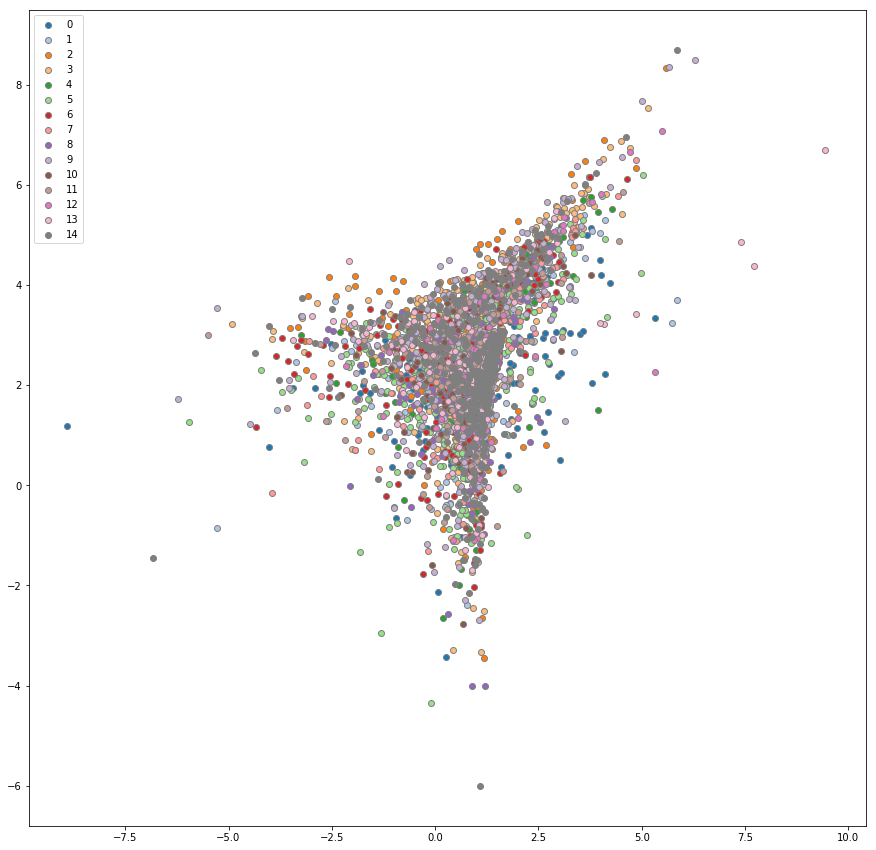

In [265]:
plot_PCA_2D(pca_2, topics=np.array(lda_cluster), topic_names=np.arange(15))

In [299]:
pca_3D = PCA(n_components=3)

In [306]:
pca_3D.fit(X)
pcafeatures_3D = np.log(np.abs(pca_3D.transform(X)))

In [309]:
import plotly as py
import plotly.graph_objs as go

py.offline.init_notebook_mode(connected=True)


x = [item[0] for item in pcafeatures_3D]
y = [item[1] for item in pcafeatures_3D]
z = [item[2] for item in pcafeatures_3D]


trace1 = go.Scatter3d(
   x=x,
   y=y,
   z=z,
   mode='markers',
   marker=dict(
       size=15,
       line=dict(
           color=np.array(lda_cluster),
           colorscale='Viridis',
           width=0.5
       ),
       opacity=0.8
   )
)


data = [trace1]
layout = go.Layout(
   margin=dict(
       l=0,
       r=0,
       b=0,
       t=0
   )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='simple-3d-scatter')

In [311]:
with open('stem_counts.pkl', 'wb') as p:
    pickle.dump(stem_counts.toarray().T, p)

OSError: [Errno 22] Invalid argument

In [312]:
with open('pcafeatures_3D.pkl', 'wb') as p:
    pickle.dump(pcafeatures_3D, p)

In [313]:
with open('topics.pkl', 'wb') as pk:
    pickle.dump(np.array(lda_cluster), pk)